In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense ,LSTM,Dropout,Activation

warnings.simplefilter('ignore')

2024-02-29 21:56:38.406140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Scratch LSTM

In [3]:
class SimpleLSTM(tf.Module):
    def __init__(self, input_size, hidden_size, output_size):
        self.Wf = tf.Variable(tf.random.normal([input_size + hidden_size, hidden_size]))
        self.Wi = tf.Variable(tf.random.normal([input_size + hidden_size, hidden_size]))
        self.Wo = tf.Variable(tf.random.normal([input_size + hidden_size, hidden_size]))
        self.Wc = tf.Variable(tf.random.normal([input_size + hidden_size, hidden_size]))
        self.Wy = tf.Variable(tf.random.normal([hidden_size, output_size]))

    def __call__(self, x, prev_hidden_state, prev_cell_state):
        # Explicitly cast to float32
        x = tf.cast(x, dtype=tf.float32)
        prev_hidden_state = tf.cast(prev_hidden_state, dtype=tf.float32)

        x_and_h = tf.concat([x, prev_hidden_state], axis=-1)

        # Forget gate
        ft = tf.sigmoid(tf.matmul(x_and_h, self.Wf))

        # Input gate
        it = tf.sigmoid(tf.matmul(x_and_h, self.Wi))

        # Output gate
        ot = tf.sigmoid(tf.matmul(x_and_h, self.Wo))

        # Candidate cell state
        cct = tf.tanh(tf.matmul(x_and_h, self.Wc))

        # Update cell state
        cell_state = ft * prev_cell_state + it * cct

        # Hidden state
        hidden_state = ot * tf.tanh(cell_state)

        # Output
        output = tf.matmul(hidden_state, self.Wy)

        return output, hidden_state, cell_state

In [4]:
# convert an array of values into a dataset matrix
look_back=1
def create_sequences(data, look_back):
    sequences = []
    targets = []
    for i in range(len(data)-look_back-1):
        sequence = data[i:(i+look_back)] # data [0]
        target = data[i+look_back] # data[0+1]
        sequences.append(sequence)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [9]:
data = df_data[['BOPD (Oil)']].values
data

array([[698.9  ],
       [822.5  ],
       [661.4  ],
       [737.7  ],
       [661.4  ],
       [712.2  ],
       [771.6  ],
       [678.3  ],
       [747.4  ],
       [694.   ],
       [800.7  ],
       [782.9  ],
       [720.6  ],
       [795.648],
       [812.688],
       [817.464],
       [808.584],
       [831.   ],
       [839.832],
       [826.344],
       [835.224],
       [830.544],
       [812.688],
       [817.464],
       [817.464],
       [822.144],
       [804.456],
       [813.312],
       [813.312],
       [813.312],
       [822.144],
       [804.456],
       [813.312],
       [813.312],
       [813.312],
       [804.456],
       [822.144],
       [821.616],
       [830.544],
       [830.544],
       [817.464],
       [817.464],
       [808.584],
       [822.144],
       [813.312],
       [804.456],
       [813.312],
       [813.312],
       [804.456],
       [803.736],
       [821.616],
       [812.688],
       [812.688],
       [796.464],
       [804.456],
       [80

In [5]:
scaler = MinMaxScaler()

In [10]:
data_normalized = scaler.fit_transform(data)

In [12]:
X, y = create_sequences(data_normalized, 1)

# LSTM Scratch Train

In [13]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Training
input_size = data.shape[1]
hidden_size = 50
output_size = data.shape[1]

lstm_model = SimpleLSTM(input_size, hidden_size, output_size)

learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate)
mse_loss = tf.losses.MeanSquaredError()

num_epochs = 10

Scratch_LSTM_loss_history = []
Scratch_LSTM_val_loss_history = []
Scratch_LSTM_accuracy_history = []
Scratch_LSTM_val_accuracy_history = []

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for inputs, targets in zip(X_train, y_train):
        with tf.GradientTape(persistent=True) as tape:
            hidden_state = tf.zeros((1, hidden_size), dtype=tf.float32)
            cell_state = tf.zeros((1, hidden_size), dtype=tf.float32)

            for i in range(len(targets)):
                input_data = tf.reshape(inputs[i], (1, input_size))
                target = tf.expand_dims(targets[i], axis=0)

                # Forward pass
                output, hidden_state, cell_state = lstm_model(input_data, hidden_state, cell_state)

                # Loss
                loss = mse_loss(target, output)
                total_loss += loss

                # Cast output and target to float32 before comparison
                correct_predictions += tf.reduce_sum(tf.cast(tf.math.abs(tf.cast(output, tf.float32) - tf.cast(target, tf.float32)) < 0.1, dtype=tf.float32))
                total_samples += tf.reduce_prod(tf.shape(output))

            # Backward pass
            grads = tape.gradient(total_loss, lstm_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, lstm_model.trainable_variables))

        accuracy = correct_predictions / tf.cast(total_samples, tf.float32)
    print(f'Epoch {epoch + 1}/{num_epochs}')

    # Validation
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    for val_inputs, val_targets in zip(X_val, y_val):
        val_hidden_state = tf.zeros((1, hidden_size), dtype=tf.float32)
        val_cell_state = tf.zeros((1, hidden_size), dtype=tf.float32)

        for i in range(len(val_targets)):
            val_input_data = tf.reshape(val_inputs[i], (1, input_size))
            val_target = tf.expand_dims(val_targets[i], axis=0)

            # Forward pass
            val_output, val_hidden_state, val_cell_state = lstm_model(val_input_data, val_hidden_state, val_cell_state)

            # Loss
            val_loss = mse_loss(val_target, val_output)
            total_val_loss += val_loss

            # Cast output and target to float32 before comparison
            correct_val_predictions += tf.reduce_sum(tf.cast(tf.math.abs(tf.cast(val_output, tf.float32) - tf.cast(val_target, tf.float32)) < 0.1, dtype=tf.float32))
            total_val_samples += tf.reduce_prod(tf.shape(val_output))

        val_accuracy = correct_val_predictions / tf.cast(total_val_samples, tf.float32)
    print(f'-Loss: {total_loss.numpy():.6f} -Validation Loss: {total_val_loss.numpy():.6f},')

    # Append values to history lists
    Scratch_LSTM_loss_history.append(total_loss.numpy())
    Scratch_LSTM_accuracy_history.append(accuracy.numpy())
    Scratch_LSTM_val_loss_history.append(total_val_loss.numpy())
    Scratch_LSTM_val_accuracy_history.append(val_accuracy.numpy())

Epoch 1/10
-Loss: 4.883385 -Validation Loss: 0.372489,
Epoch 2/10
-Loss: 3.348327 -Validation Loss: 0.377102,
Epoch 3/10
-Loss: 3.312247 -Validation Loss: 0.382469,
Epoch 4/10
-Loss: 3.275745 -Validation Loss: 0.388220,
Epoch 5/10
-Loss: 3.239472 -Validation Loss: 0.394284,
Epoch 6/10
-Loss: 3.204280 -Validation Loss: 0.400612,
Epoch 7/10
-Loss: 3.170526 -Validation Loss: 0.407162,
Epoch 8/10
-Loss: 3.138349 -Validation Loss: 0.413902,
Epoch 9/10
-Loss: 3.107792 -Validation Loss: 0.420802,
Epoch 10/10
-Loss: 3.078851 -Validation Loss: 0.427835,


In [ ]:
columns = ['Choke', 'Psig', 'APsig', 'BOPD (Oil)', 'MMSCFD (Gas)', 'BWPD (Air)']

In [ ]:
df_data = pd.read_excel('data.xlsx')
df_data = df_data[columns]

In [ ]:
# fill error data
df_data = df_data.ffill()

# LSTM Scratch Loss Graph

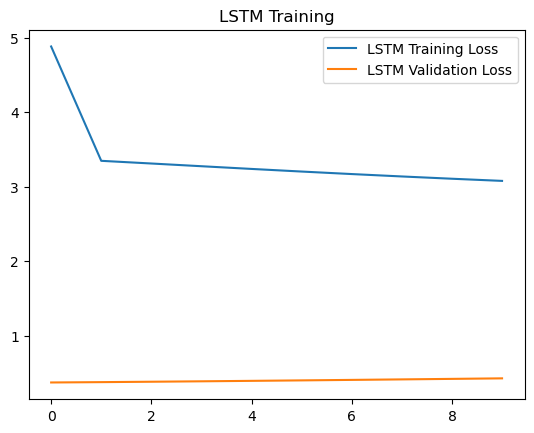

In [16]:
# Plot training and validation loss for LSTM
plt.plot(Scratch_LSTM_loss_history, label='LSTM Training Loss')
plt.plot(Scratch_LSTM_val_loss_history, label='LSTM Validation Loss')
plt.legend()
plt.title('LSTM Training')
plt.show()

# Evaluation

In [17]:
# Initialize an empty list to store predicted values
predicted_values = []

# Testing
total_test_loss = 0
correct_test_predictions = 0
total_test_samples = 0

for inputs, targets in zip(X_val, y_val):
    hidden_state = tf.zeros((1, hidden_size), dtype=tf.float32)
    cell_state = tf.zeros((1, hidden_size), dtype=tf.float32)

    predictions_per_sequence = []  # List to store predicted values for each sequence

    for i in range(len(targets)):
        input_data = tf.reshape(inputs[i], (1, input_size))
        target = tf.expand_dims(targets[i], axis=0)

        # Forward pass
        output, hidden_state, cell_state = lstm_model(input_data, hidden_state, cell_state)

        # Append the predicted value to the list
        predictions_per_sequence.append(output.numpy())

        # Loss
        test_loss = mse_loss(target, output)
        total_test_loss += test_loss

        # Cast output and target to float32 before comparison
        correct_test_predictions += tf.reduce_sum(tf.cast(tf.math.abs(tf.cast(output, tf.float32) - tf.cast(target, tf.float32)) < 0.1, dtype=tf.float32))
        total_test_samples += tf.reduce_prod(tf.shape(output))

    # Append the list of predicted values for the current sequence to the overall list
    predicted_values.append(predictions_per_sequence)

print(f'Test Loss: {total_test_loss.numpy():.6f}')

# Convert the list of predicted values to a NumPy array
predicted_values = np.array(predicted_values)

Test Loss: 0.427835


In [18]:
y_pred_scratch = predicted_values.reshape(-1,1)

In [19]:
from sklearn.metrics import mean_absolute_error

In [20]:
MAE_scratch = mean_absolute_error(y_pred_scratch, y_val)

print('The Mean Absolute Error is: {}'.format(MAE_scratch))

The Mean Absolute Error is: 0.08159433789198356


In [30]:
def plot2Lines(data,actual_y,predicted_y):
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    Date_column= list(data['Psig'])
    axes.plot(Date_column[len(Date_column)-len(actual_y):], actual_y, color = 'red', label = 'actual')
    axes.plot(Date_column[len(Date_column)-len(actual_y):], predicted_y, color = 'blue', label = 'predicted')
    #axes.xticks(np.arange(0,394,50))
    plt.title('Actual V.s Predicted')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.show()

In [35]:
y_val

array([[0.78879577],
       [0.80163211],
       [0.85006617],
       [0.78879577],
       [0.83762682],
       [0.85191884],
       [0.89836789],
       [0.78879577],
       [0.66993824],
       [0.88828849],
       [0.9094839 ],
       [0.83762682],
       [0.85006617],
       [0.80163211],
       [0.75333039],
       [0.28010587],
       [0.80163211],
       [0.83762682],
       [0.74022938],
       [0.83762682],
       [0.80163211]])

In [32]:
y_pred_scratch

array([[0.81104124],
       [0.81879133],
       [0.8254987 ],
       [0.8273749 ],
       [0.8265168 ],
       [0.81879133],
       [0.8079936 ],
       [0.8209288 ],
       [0.8274422 ],
       [0.38281342],
       [0.78036743],
       [0.8265168 ],
       [0.8250368 ],
       [0.81879133],
       [0.8254987 ],
       [0.        ],
       [0.8254987 ],
       [0.8209288 ],
       [0.5625465 ],
       [0.8265168 ],
       [0.81879133]], dtype=float32)

ValueError: x and y must have same first dimension, but have shapes (106,) and (21, 1)

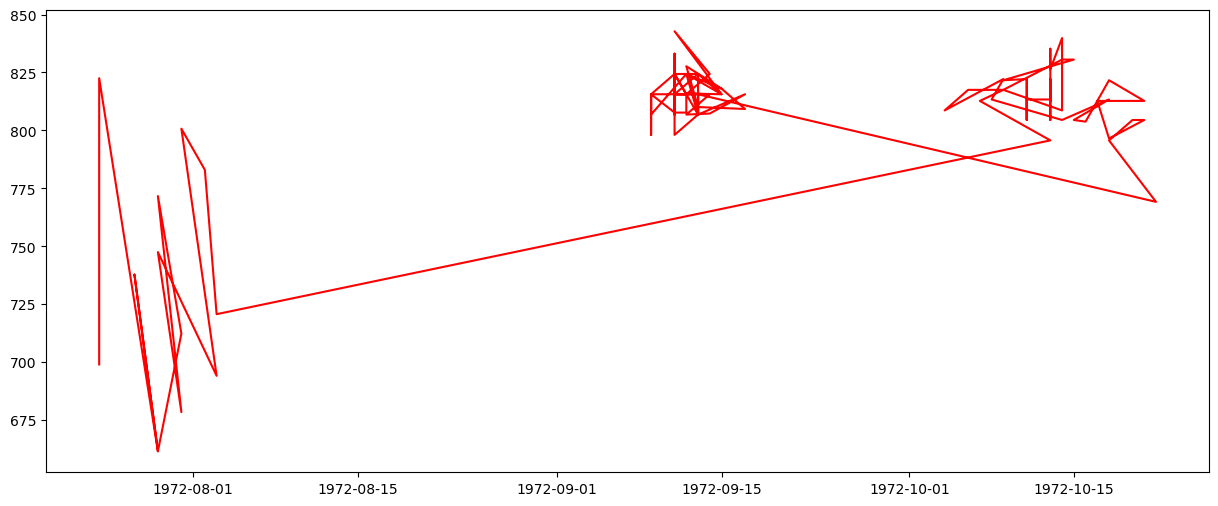

In [31]:
plot2Lines(df_data,actual_y=df_data[['BOPD (Oil)']],predicted_y=y_pred_scratch)